# Notebook for CE Anlaysis using markov chain models
#### Brandon Chan July 2020

### Import packages

In [1]:
import sys
sys.path.insert(0,"../src")

import pandas as pd # Dataframe structure and reading of excel files
import numpy as np # Scientific computing - used for n-dimensional arrays, numerical functions
import matplotlib.pyplot as plt # Plotting package
import seaborn as sns # Another plotting package
import os # for file path things
from arch.bootstrap import IIDBootstrap # Bootstrap analysis
from markov_modeling import run_model # code for running/iterating model

### Set cycle length (needed to adjust to QALY)
Assumes that both the basecase and treatment arms have the same cycle length!

In [2]:
#---------------------------------------------------------------------------------------------------
# Read in excel workbook and assign each sheet to a dataframe
#---------------------------------------------------------------------------------------------------
specification_df = pd.read_excel('../model_specifications/test_parameters_base.xlsx', 'specification', header=None, index_col=0)
cycle_length = specification_df.loc['cycle_length'].values[0]

### Option 1) Load existing model outputs if they exist

In [3]:
pop_base = np.load('../model_outputs/test_base_20-07-2020_population.npy')
cost_base = np.load('../model_outputs/test_base_20-07-2020_costs.npy')
util_base = np.load('../model_outputs/test_base_20-07-2020_utilities.npy')

pop_treat = np.load('../model_outputs/test_treat_20-07-2020_population.npy')
cost_treat = np.load('../model_outputs/test_treat_20-07-2020_costs.npy')
util_treat = np.load('../model_outputs/test_treat_20-07-2020_utilities.npy')

### Option 2) Run model for base-case and treatment arms based on structure and paramters outlined in excel files

In [4]:
pop_base, cost_base, util_base = run_model('../model_specifications/test_parameters_base.xlsx', save=False, model_name='test_base')
pop_treat, cost_treat, util_treat = run_model('../model_specifications/../model_specifications/test_parameters_treat.xlsx', save=False, model_name='test_treat')

file and parameters loaded...
beginning iterations...
model done...
total time: 0.27 seconds || mean time per iteration: 0.0 seconds
calculating costs and utilities...
done costs and utilities...

file and parameters loaded...
beginning iterations...
model done...
total time: 0.24 seconds || mean time per iteration: 0.0 seconds
calculating costs and utilities...
done costs and utilities...



### Consense raw model outputs into desired numbers

In [5]:
#calculate sum at each time point (assign to bottom row)
# result array shape: [num_iterations, num_timesteps]
# each row is the sum of the costs/utilitys at time point t of an iteration
cost_sum_per_cycle_base = np.sum(cost_base, axis=1)
utility_sum_per_cycle_base = np.sum(util_base, axis=1)

cost_sum_per_cycle_treat = np.sum(cost_treat, axis=1)
utility_sum_per_cycle_treat = np.sum(util_treat, axis=1)

# Calculate the total cost of an iteration
cost_sum_per_iteration_base = np.sum(cost_sum_per_cycle_base, axis=1)
utility_sum_per_iteration_base = np.sum(utility_sum_per_cycle_base, axis=1)

cost_sum_per_iteration_treat = np.sum(cost_sum_per_cycle_treat, axis=1)
utility_sum_per_iteration_treat = np.sum(utility_sum_per_cycle_treat, axis=1)

# Difference in costs/utilities when comparing each arm per iteration
# ONLY GOOD FOR PLOTTING
c = cost_sum_per_iteration_treat - cost_sum_per_iteration_base
u = utility_sum_per_iteration_treat - utility_sum_per_iteration_base

# Dataframe for ICER CI / Bootstrap Calculations
results_data = pd.DataFrame({'cost_treat':cost_sum_per_iteration_treat,
                             'cost_base':cost_sum_per_iteration_base,
                             'utility_treat':utility_sum_per_iteration_treat,
                             'utility_base':utility_sum_per_iteration_base})

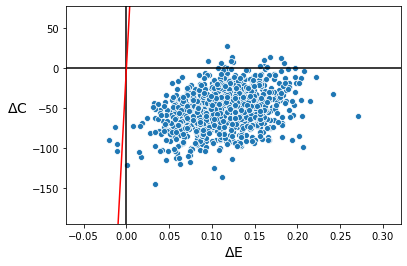

In [6]:
# Make the CE plane plot
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.ylabel(r'$\Delta$C', rotation=0, fontsize=14, labelpad=14)
plt.xlabel(r'$\Delta$E', fontsize=14)
sns.scatterplot(x=u, y=c)

# Plots some threshold line...
x = np.linspace(min(u), max(u), 100)
y = 20000*x
plt.plot(x, y, '-r')

plt.ylim(min(c)-50, max(c)+50) # Add padding to axis limits
plt.xlim(min(u)-0.05, max(u)+0.05)

plt.show()

### ICER

In [7]:
delta_mean_utility = utility_sum_per_iteration_treat.mean() - utility_sum_per_iteration_base.mean() #Average util of treat - average util of basecase
delta_mean_cost = cost_sum_per_iteration_treat.mean() - cost_sum_per_iteration_base.mean() #Average cost of treat - average cost of basecase

delta_mean_cost/delta_mean_utility

-463.976050195348

### Bootstrap for 95% CI

In [8]:
def func_icer(x):
    '''
    Function to return the ICER of the average of the boot strap sample.
    Input: x = rows of results_dataframe that were indexed from the bootstrap sample
               has 4 columns for cost_treat, cost_base, utility_treat, utility_base
    Output: ICER calculated from the iterations present in x
    
              mean(cost_treat) - mean(cost_base)
    ICER = ----------------------------------------
           mean(utility_treat) - mean(utility_base)
    '''
    return (x['cost_treat'].mean() - x['cost_base'].mean()) / (x['utility_treat'].mean() - x['utility_base'].mean())

bs = IIDBootstrap(results_data) #use a "dummy" of array indicies to sample from. Needed to correctly calculate ICER of the average
ci = bs.conf_int(func_icer, 1000, method='bca') #bias-corrected and accelerated method

#print(ci)

print(round(delta_mean_cost/delta_mean_utility,2),'(',round(ci[0][0],2),'to',round(ci[1][0],2),')')

-463.98 ( -484.4 to -446.68 )


### Example using just the cea_analysis() function from analysis_helpers.py

In [9]:
import sys
sys.path.insert(0,"../src")

from analysis_helpers import cea_analysis

file and parameters loaded...
beginning iterations...
model done...
total time: 0.22 seconds || mean time per iteration: 0.0 seconds
calculating costs and utilities...
done costs and utilities...

file and parameters loaded...
beginning iterations...
model done...
total time: 0.22 seconds || mean time per iteration: 0.0 seconds
calculating costs and utilities...
done costs and utilities...

ICER with 95% CI:
-493.56 ( -514.27 to -476.23 )


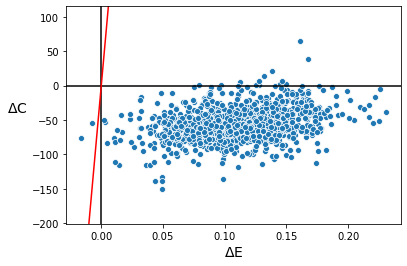

In [10]:
cea_analysis('../model_specifications/test_parameters_base.xlsx','../model_specifications/test_parameters_test.xlsx')

# Extras

### Schematic of model output array:
<img src="../img/outputarray.png" alt="Drawing" style="width: 500px;"/>

### Calculating cost and utility per iteration:
\begin{equation*}
Cost_i = \sum_{j=1}^c\sum_{k=1}^n P_{ijk}C_j \\
Utility_i = \sum_{j=1}^c\sum_{k=1}^n P_{ijk}U_j(\frac{cyclelength}{365}) \\
\end{equation*}
P = [iterations x states x cycles] sized array representing the model 
output<br>
C = mappings of cost per state <br>
U = mappings of utility weight per state <br>
i = iteration <br>
c = number of cycles <br>
n = number of states

### Calculating ICER
#### Calculate mean of costs and utilities across iterations
\begin{equation*}
\text{MeanCost}_{\text{treat}} = \frac{\sum_{i=1}^{\text{iterations}}\text{Cost}_i^{\text{treat}}}{\text{iterations}} \\
\text{MeanCost}_{\text{base}} = \frac{\sum_{i=1}^{\text{iterations}}\text{Cost}_i^{\text{base}}}{\text{iterations}} \\
\text{MeanUtility}_{\text{treat}} = \frac{\sum_{i=1}^{\text{iterations}}\text{Utility}_i^{\text{treat}}}{\text{iterations}} \\
\text{MeanUtility}_{\text{base}} = \frac{\sum_{i=1}^{\text{iterations}}\text{Utility}_i^{\text{base}}}{\text{iterations}} \\
\end{equation*}

#### ICER
\begin{equation*}
\text{ICER} = \frac{\text{MeanCost}_{treat} - \text{MeanCost}_{base}}{\text{MeanUtility}_{treat} - \text{MeanUtility}_{base}}
\end{equation*}

## Scratch code

In [11]:
# For plotting a bounding box on the CE plane. 
'''
cu = max(c)
cl = min(c)
uu = max(u)
ul = min(u)
d = [(uu,uu),(cl,cu),'b',
     (uu,ul),(cl,cl),'b',
     (ul,uu),(cu,cu),'b',
     (ul,ul),(cl,cu),'b']
plt.plot(*d)

mx = utility_sum_per_iteration_treat.mean() - utility_sum_per_iteration_base.mean() #Average util of treat - average util of basecase
my = cost_sum_per_iteration_treat.mean() - cost_sum_per_iteration_base.mean() #Average cost of treat - average cost of basecase
plt.plot(mx, my, 'r*')
'''
print()